In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, \
                                    UpSampling2D, Input, Flatten, Reshape, InputLayer
import matplotlib.pyplot as plt
import numpy as np

In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
latent_dimension = 256

### Define encoder

In [5]:
encoder = tf.keras.Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(latent_dimension),
], name='encoder')

### Define decoder

In [6]:
decoder = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dimension,)),
    Dense(units=7*7*32, activation='relu'),
    Reshape(target_shape=(7, 7, 32)),
    Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='SAME', activation='relu'),
    Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding='SAME', activation='relu'),
    Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding='SAME')
], name='decoder')

### Combine encoder and decoder into autoencoder

In [8]:
inp = Input((28, 28, 1))
output1 = encoder(inp)
output2 = decoder(output1)

auto_encoder = tf.keras.Model(inp, output2)

## Train autoencoder

In [15]:
auto_encoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
auto_encoder.fit(X_train, X_train, batch_size=128, epochs=100, verbose=1)

Train on 60000 samples
Epoch 1/100
20736/60000 [=========>....................] - ETA: 17s - loss: 37.3677 - accuracy: 0.6385

## Visualize result

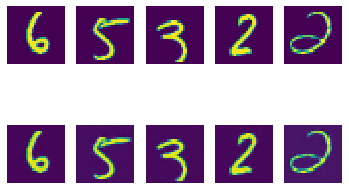

In [25]:
choice = np.random.choice(X_test.shape[0], 5, replace=False)
x = X_test[choice]
x_pred = auto_encoder.predict(x)

fig, ax = plt.subplots(2, 5, squeeze=False)

for i in range(x.shape[0]):
    ax[0][i].imshow(x[i].reshape((28, 28)))
    ax[1][i].imshow(x_pred[i].reshape(28, 28))
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.show()